Import Libraries:

In [5]:
%matplotlib inline
# %matplotlib notebook
from sklearn.model_selection import train_test_split
import numpy as np
import qutip as qt
from qiskit.quantum_info import Statevector, DensityMatrix, entropy, partial_trace
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute
# from vae import * 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt

2023-05-23 09:37:45.306272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 09:37:45.415743: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-23 09:37:45.418272: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-23 09:37:45.418283: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [6]:
fig_size_dim    = 4
golden_ratio    = (1+np.sqrt(5))/2
fig_size        = (fig_size_dim, fig_size_dim/golden_ratio)

def plot_style():
    font_size       = 12
    dpi             = 200

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "sans-serif",
              'font.sans-serif': ["Helvetica"],
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'text.usetex': True,
             }

    plt.rcParams.update(params)
plot_style()

In [7]:
def circuit(theta):
    q = QuantumRegister(2,'q')
    circuit = QuantumCircuit(q)
    circuit.h(q[0])
    circuit.cry(theta,q[0],q[1])
    return circuit

def get_dm(theta):
    state = Statevector.from_int(0, 2**2)
    state = state.evolve(circuit(theta))
    return DensityMatrix(state)


def get_u(n):
    z = np.random.randn(n,n)/np.sqrt(2.0)
    q,r = np.linalg.qr(z)
    d = np.diagonal(r)
    ph = d/np.absolute(d)
    q = np.multiply(q,ph,q)
    return q

def apply_u(dm):
    UaUb = qt.Qobj(np.kron(get_u(2),get_u(2)),dims = [[2, 2], [2, 2]])
    return  UaUb * dm * UaUb.dag()  

In [8]:
n_points = 51#101#51#41#21
n_samples = 50
scan_arr = np.linspace(0,np.pi,n_points)

rho_arr_noisy = np.zeros((n_points,n_samples,4,4))

for i, theta in enumerate(scan_arr):   
        
    dm = get_dm(theta) 
    
    for inx, s in enumerate(range(n_samples)):
        rho_arr_noisy[i,inx] = apply_u( qt.Qobj(dm.data,dims=[[2,2],[2,2]]))
            
rho_arr_noisy = np.reshape(rho_arr_noisy,(n_points*n_samples,16))

/tmp/ipykernel_304986/1666128077.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  rho_arr_noisy[i,inx] = apply_u( qt.Qobj(dm.data,dims=[[2,2],[2,2]]))


In [9]:
alpha_arr = np.zeros(len(rho_arr_noisy))
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            alpha_arr[cnt] = theta
            cnt += 1


X_train, X_test, y_train, y_test = train_test_split(rho_arr_noisy, alpha_arr, random_state=42)
concurrence_arr = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in X_test])

Define Hyperparameters:

In [10]:
batch_size = 64
beta = 0.75
learning_rate = 0.001
lat_dim = 1
hidden_act = "tanh"
final_act = "linear"

Load trained VAE:

In [20]:
import keras.backend as K

def custom_fid(y_true, y_pred):
    rho = K.reshape(y_true,(4,4))
    sig = K.reshape(y_pred,(4,4))
    
    return 1#K.square(  tf.linalg.trace(K.sqrt(K.sqrt(rho)*sig*K.sqrt(rho)))  )

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a p-vector."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, beta_factor, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta_factor
        self.beta_scale = 1
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss")
        self.val_loss_tracker = tf.keras.metrics.Mean(
            name="val_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.val_loss_tracker
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(tf.keras.losses.mean_squared_error(data, reconstruction), axis=-1))
                tf.reduce_sum(custom_fid(data, reconstruction), axis=-1))

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + self.beta_scale * self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }

    def test_step(self, data):
        _, _, z_test = self.encoder(data[0])
        test_reconstruction = self.decoder(z_test)
        val_loss = tf.reduce_mean(
            tf.reduce_sum(tf.keras.losses.mean_squared_error(data[0], test_reconstruction), axis=-1))
        self.val_loss_tracker.update_state(val_loss)
        return {"val_loss": self.val_loss_tracker.result()}


def vae_mlp_4x4(latent_dim, act_func, f_act):
    encoder_inputs = tf.keras.Input(shape=16)
    x = encoder_inputs
    x = tf.keras.layers.Dense(16, activation=act_func)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(8, activation=act_func)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(4, activation=act_func)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = tf.keras.Input(shape=(latent_dim,))
    x = latent_inputs
    x = tf.keras.layers.Dense(4, activation=act_func)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(8, activation=act_func)(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(16, activation=act_func)(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    decoder_outputs = tf.keras.layers.Dense(16, activation=f_act)(x)
    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return encoder, decoder

encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

vae_noisy = VAE(encoder, decoder, beta)
vae_noisy.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae_noisy.fit(X_test, epochs=750, batch_size=64, verbose=0) 

z_mean, z_log_var, z = vae_noisy.encoder.predict(X_test)

ValueError: in user code:

    File "/home/felix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/felix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/felix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/tmp/ipykernel_304986/391077703.py", line 49, in train_step
        tf.reduce_sum(custom_fid(data, reconstruction), axis=-1))

    ValueError: Invalid reduction dimension -1 for input with 0 dimensions. for '{{node Sum}} = Sum[T=DT_INT32, Tidx=DT_INT32, keep_dims=false](Sum/input, Sum/reduction_indices)' with input shapes: [], [] and with computed input tensors: input[1] = <-1>.


ValueError: in user code:

    File "/home/felix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/felix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/felix/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/tmp/ipykernel_304986/948789869.py", line 41, in train_step
        tf.reduce_sum(custom_fid(data, reconstruction), axis=-1))

    ValueError: Invalid reduction dimension -1 for input with 0 dimensions. for '{{node Sum}} = Sum[T=DT_FLOAT, Tidx=DT_INT32, keep_dims=false](Square, Sum/reduction_indices)' with input shapes: [], [] and with computed input tensors: input[1] = <-1>.


Investigate Latent Space

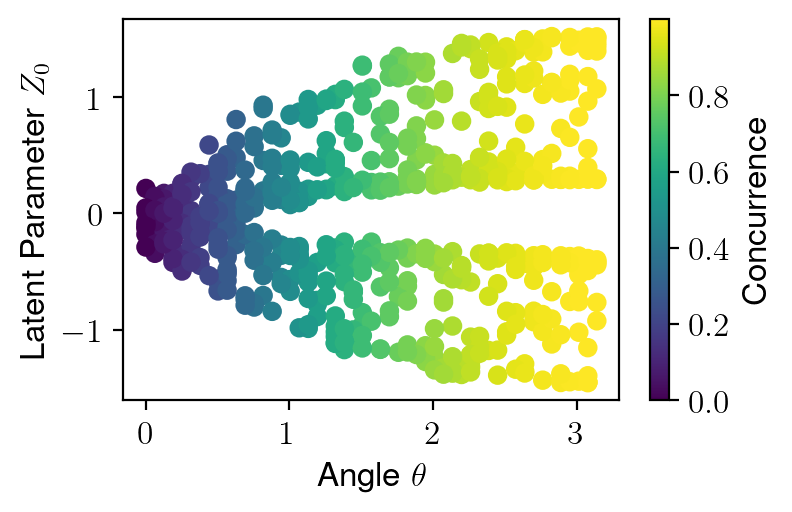

In [13]:
plot_scatter(y_test,z_mean[:,0],concurrence_arr,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)